# 1. Introductioning the data

This notebook contains my basic solution to train a model on a task defined on the dataset shared on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets) accessible at http://archive.ics.uci.edu/ml/datasets/EMG+data+for+gestures.


# 2. Dataset

The dataset contains Electromyography (EMG) recording from the wrist of 36 subjects who were asked to perform one of the 7 predetermined hand gestures. The recording constitutes of 8 channels each corresponding to a sensor. Every subject is asked to perform all of the first 6 gestures while only one subject is also asked to perform the last gesture. The data is structured and saved in CSV-like format. Entries are separated with tab('\t'). The columns are `time`, `channel1` to `channel8`, `class`. The column `class` represents the gesture category. Class zero corresponds to the resting state (no gesture).   

# 3. Loading the data

Before anything, we need to import a few packages so we can conveniently load, visualize and manipulate the data.

In [1]:
import os # to walk through the recording files
import pandas as pd # to easily read and manipulate the data
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # another library for visualization


from utils import load_emg_recording

In the following code segment, we walk through the recording file of each subject and append the content to a pandas DataFrame so everything is stored in a big structured table (`df_all`).

In [2]:
df_all = None 
# get the list of directories in the EMG dataset
dirname = './data/EMG_data_for_gestures-master'
for filename in os.listdir(dirname):
    file = os.path.join(dirname, filename)
    # 
    for subfilename in os.listdir(file):
        subfile = os.path.join(file, subfilename)
        df = pd.read_csv(subfile, sep='\t')
        df['subject'] = int(filename)
        if df_all is None:
            df_all = df
        else:
            df_all = pd.concat([df_all, df], ignore_index=True)

Checking the number of samples per class (how imblance data is).

<AxesSubplot:xlabel='class', ylabel='count'>

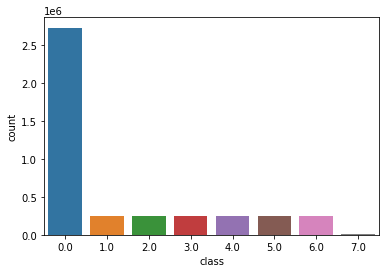

In [3]:
sns.countplot(x = df_all['class'])

Checking the missing data

In [4]:
df_all.isnull().any()

time        False
channel1    False
channel2    False
channel3    False
channel4    False
channel5    False
channel6    False
channel7    False
channel8    False
class        True
subject     False
dtype: bool

Let's see the `NaN` value belongs to which class

In [5]:
df_all[df_all.isnull().any(axis=1)]

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject
3985214,97144,-0.00002,-0.00003,-0.00003,-0.00002,-0.00002,0.0,0.0,-0.00001,NaN,34


In [6]:
df_all.loc[3985210:3985218]

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject
3985210,97140,-0.00002,-0.00003,-0.00003,-0.00002,-0.00002,0.00000,0.00000,-0.00001,0.0,34
3985211,97141,-0.00002,-0.00003,-0.00003,-0.00002,-0.00002,0.00000,0.00000,-0.00001,0.0,34
3985212,97142,-0.00002,-0.00003,-0.00003,-0.00002,-0.00002,0.00000,0.00000,-0.00001,0.0,34
3985213,97143,-0.00002,-0.00003,-0.00003,-0.00002,-0.00002,0.00000,0.00000,-0.00001,0.0,34
3985214,97144,-0.00002,-0.00003,-0.00003,-0.00002,-0.00002,0.00000,0.00000,-0.00001,NaN,34
3985215,1,-0.00001,-0.00002,-0.00003,-0.00001,0.00000,0.00000,-0.00002,0.00000,0.0,34
3985216,3,-0.00001,-0.00002,-0.00003,-0.00001,0.00000,0.00000,-0.00002,0.00000,0.0,34
3985217,4,0.00003,0.00004,0.00005,0.00002,-0.00001,-0.00001,-0.00002,-0.00002,0.0,34
3985218,5,-0.00001,0.00000,0.00001,-0.00001,-0.00004,-0.00001,-0.00002,-0.00002,0.0,34


The `NaN` value belongs to `calss 0`.

Visualize the time series corresponding to the subject that we predicted. (example: `Subject 17` )

In [7]:
# Path to the actual data (example `Subject 17`)
path='data/EMG_data_for_gestures-master/17/2_raw_data_11-20_23.03.16.txt'
df = load_emg_recording(path, True)

In [8]:
# Path to the predicted data (example `Subject 17`)
df_r = pd.read_csv('res/result.txt')

In [9]:
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

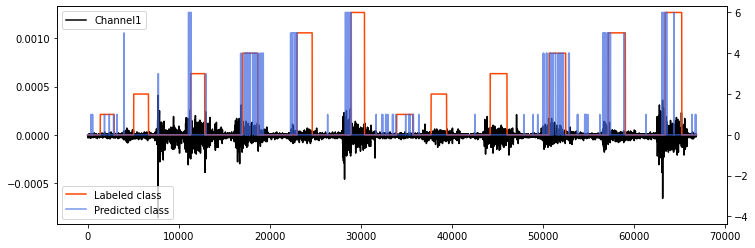

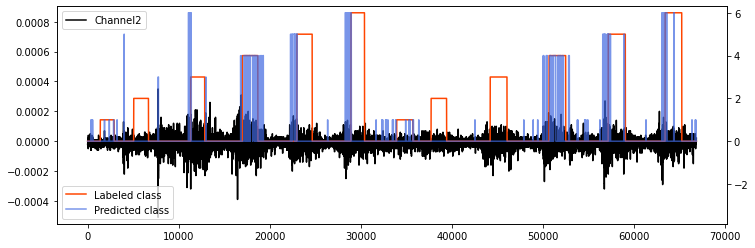

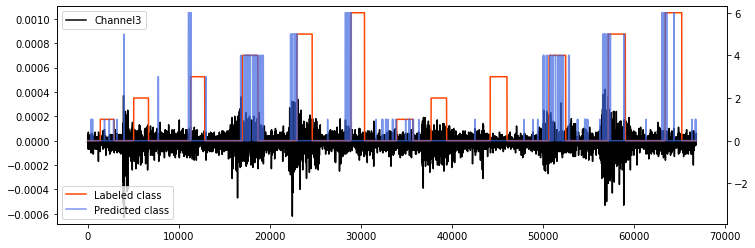

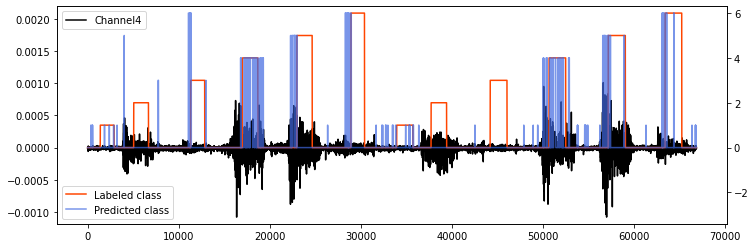

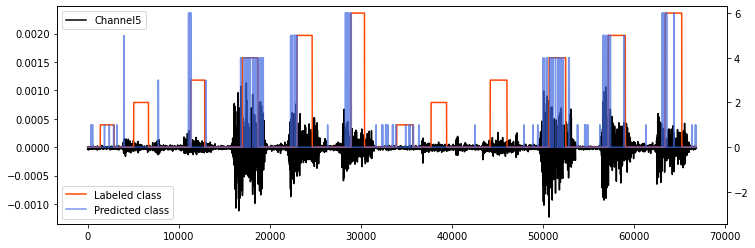

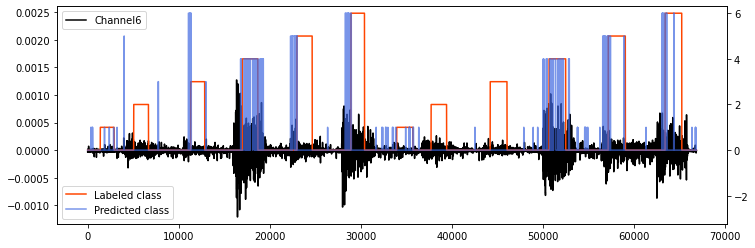

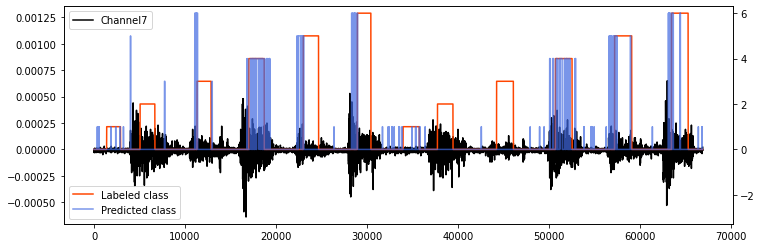

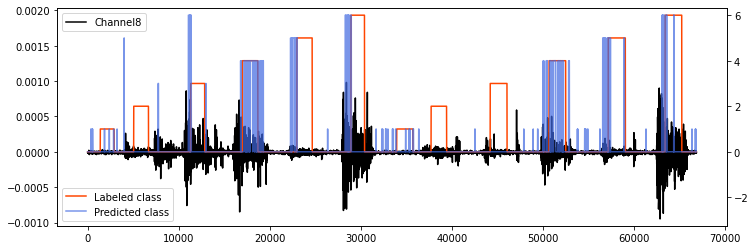

In [10]:
num_channel = 8
for i in range(1, num_channel+1):
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx() 
    ax1.plot(df.index, df['channel'+str(i)], color='k',label='Channel{}'.format(i))
    ax2.plot(df.index, df['class'], color='orangered',label='Labeled class')
    ax2.plot(df_r.index, df_r['0'], color='royalblue', label='Predicted class', alpha= 0.7)
    align_yaxis(ax1, ax2)
    ax1.legend(loc = 'upper left')
    ax2.legend()
    plt.show()


# CLI demo

Locate the root of the project and install the requirements

In [11]:
!pip install -r requirements.txt

### print cli usage

In [ ]:
!python cli.py --help

Usage: cli.py [OPTIONS] COMMAND [ARGS]...

  group definition for click commands.

Options:
  --help  Show this message and exit.

Commands:
  infer-emg  predict gesture class based on the EMG data
  train-emg  trains a model on data extracted from text files within...


### Training

```bash
$ python cli.py train-emg -t <path_to_dir_containing_EMG_recordings> -w <window_size> -d <dir_to_save_trained_model> -o <name_of_output_file>
```

Example:

In [ ]:
!python cli.py train-emg -t .\data\EMG_data_for_gestures-master\01\ -w 100 -d deployed_models -o train_on_01.pkl

^C


### Inference

```bash
$ python cli.py infer-emg -r <path_to_dir_containing_EMG_recordings> -m <path_to_dir_containing_trained_model> -o <path_to_save_the_inference_results>
```

Example:

In [ ]:
!python cli.py infer-emg -r  data/EMG_data_for_gestures-master/17/2_raw_data_11-20_23.03.16.txt -m deployed_models/RandomForestClassifier_w100___2022-06-02.pkl -o inference_output/inference17_2.txt

^C
